In [ ]:
!pip install seaborn
!pip install mixtend
!pip install tensorflow


In [105]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/87/0f/7630ee4fea60ebab5b0e3c35df570cb295c91ece537231a38105c0f243e8/lightgbm-4.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -------------------------- ------------- 0.9/1.3 MB 18.5 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 20.6 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcl
 
from matplotlib.colors import LinearSegmentedColormap
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["font.family"] = 'NanumGothic'
sns.set(font='NanumGothic')

# minus(-) 기호 대체 설정
plt.rcParams['axes.unicode_minus'] = False

# seaborn에서도 한글 폰트 적용
sns.set(font='NanumGothic')

In [3]:
ICU = pd.read_csv('./ICU.csv')

C:\Users\kinsh\AppData\Local\Temp\ipykernel_2164\1808924694.py:1: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  ICU = pd.read_csv('./ICU.csv')


# 중환자 연관관계

In [4]:
# 변수로 필요 없는 컬럼 삭제

ICU = ICU.drop(['WARD_CONT'], axis=1)  #중환자임을 나타냄
ICU = ICU.drop(['PRSC_CAPA'], axis=1) # 약 처방량을 병합해서 총 처방량 컬럼만 사용하면됨

In [5]:
value_counts = ICU['PRSC_CLS_NM'].value_counts()
value_counts

AB    39087
AF      929
AV      736
Name: PRSC_CLS_NM, dtype: int64

In [6]:
value_counts = ICU['MAIN_DIAG_YN'].value_counts()
value_counts

N, Y    40585
Y         167
Name: MAIN_DIAG_YN, dtype: int64

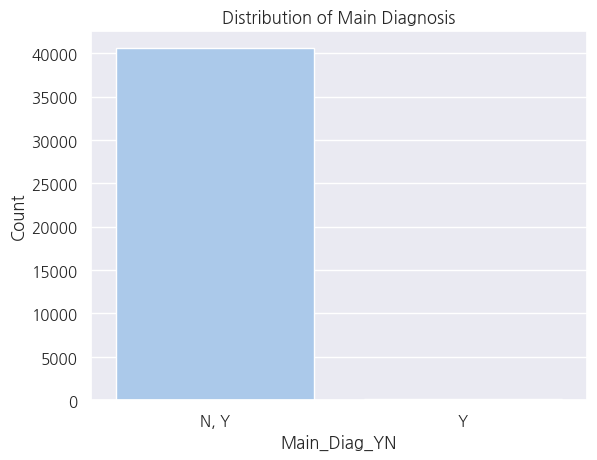

In [7]:
# 시각화
sns.barplot(x=value_counts.index, y=value_counts.values, palette="pastel")
plt.xlabel('Main_Diag_YN')
plt.ylabel('Count')
plt.title('Distribution of Main Diagnosis')
plt.show()

In [8]:
value_counts = ICU['WTHN30_REHOSP_YN'].value_counts()
value_counts

N    31356
Y     9396
Name: WTHN30_REHOSP_YN, dtype: int64

- 주 진단여부는 데이터 양 차이가 너무 커서 지지도가 높게 나오는 것으로 판단 따라서 제거
- 처방 분류 코드는 차이가 많이 나긴 하나 무시하면 안될 수치라 판단하여 계속 진행
- 30일 이내 재방문 데이터는 유의미 하다 판단

In [9]:
ICU = ICU.drop(['MAIN_DIAG_YN'], axis=1) 

## 사용할 변수 정리
- INGR_NM   : 처방 받은 약 종류
- PRSC_NT   : 약 처방 일수
- TPRSC_CAPA  :  약 총 처방량
- PRSC_CLS_NM :  처방 분류 코드
- ATC_CONT :  ATC내용 (의약분류코드)
- DBP  : 이완기 혈압
- SBP  : 수축기 혈압
- ICD10CD   : ICD10코드 (국제 질병 분류)
- DIAG_NM   : 진단명
- AGRDE     : 연령대
- SEX_CD    : 성별  (M : 남성  F : 여성)
- RSLT_CONT  :  호전됨, 위험 (환자 징후 예측 타겟)
- WTHN30_REHOSP_YN  : 30일 이내의 병원 재방문 여부 (Y,N)

In [11]:
ICU.set_index('VTHOS_NO', inplace=True)

In [12]:
ICU

,INGR_NM,PRSC_NT,TPRSC_CAPA,PRSC_CLS_NM,ATC_CONT,DBP,SBP,맥박,체온,호흡,ICD10CD,DIAG_NM,AGRDE,SEX_CD,RSLT_CONT,WTHN30_REHOSP_YN
VTHOS_NO,,,,,,,,,,,,,,,,
0x000d740f3af5d04f9f329e41cf15fefcbf747447dd55ea155c9be9ef3615a26d,"Teicoplanin(IM,IV,IVF)(항생제), Cefixime, Meropen...",27,1020.000,AB,NaN,51,89,135,36.9,14.0,"A41.9 , J40 , J21.9 , R53 , J18.9 , I48.0,...","Bronchiolitis, Pneumonia, Paroxysmal atrial fi...",90대,M,호전됨,N
0x000d740f3af5d04f9f329e41cf15fefcbf747447dd55ea155c9be9ef3615a26d,"Teicoplanin(IM,IV,IVF)(항생제), Cefixime, Meropen...",27,1020.000,AB,NaN,51,89,135,36.9,14.0,"A41.9 , J40 , J21.9 , R53 , J18.9 , I48.0,...","Bronchiolitis, Pneumonia, Paroxysmal atrial fi...",90대,M,호전됨,N
0x000d740f3af5d04f9f329e41cf15fefcbf747447dd55ea155c9be9ef3615a26d,"Teicoplanin(IM,IV,IVF)(항생제), Cefixime, Meropen...",27,1020.000,AB,NaN,51,89,135,36.9,14.0,"A41.9 , J40 , J21.9 , R53 , J18.9 , I48.0,...","Bronchiolitis, Pneumonia, Paroxysmal atrial fi...",90대,M,호전됨,N
0x000d740f3af5d04f9f329e41cf15fefcbf747447dd55ea155c9be9ef3615a26d,"Teicoplanin(IM,IV,IVF)(항생제), Cefixime, Meropen...",27,1020.000,AB,J01DH02,51,89,135,36.9,14.0,"A41.9 , J40 , J21.9 , R53 , J18.9 , I48.0,...","Bronchiolitis, Pneumonia, Paroxysmal atrial fi...",90대,M,호전됨,N
0x0013131e3997eab3578b9fb416e237319e1473845c038f45970265f03692cb5a,"Ciprofloxacin(IVF), Cefazolin Na(IV,IM,IVF)(Na...",28,1065.400,AB,J01DD04,141.0,205.0,112.0,36.0,19.0,"J81 , I50.04, K25.91, I73.9 , F79.9 , K59.09...","Type 2 diabetes mellitus, with end-stage ranal...",40대,M,호전됨,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xfffbc588a9f7c77ff76258fabe119256f048bfcf8ae1a8c877d921b584609a3a,"Vancomycin HCl(IVF), Moxifloxacin HCl(IVF), Pi...",150,11622.775,AB,J01CR05,88.0,151.0,95.0,36.6,18.0,"R31.8, F00.9 , F32.9 , I10.9, R65.9, E79.0 , J...","Dyspnea, Dyslipidemia, Special screening exami...",80대,M,호전됨,Y
0xfffbc588a9f7c77ff76258fabe119256f048bfcf8ae1a8c877d921b584609a3a,"Vancomycin HCl(IVF), Moxifloxacin HCl(IVF), Pi...",150,11622.775,AB,J01CR05,88.0,151.0,95.0,36.6,18.0,"R31.8, F00.9 , F32.9 , I10.9, R65.9, E79.0 , J...","Dyspnea, Dyslipidemia, Special screening exami...",80대,M,호전됨,Y
0xfffbc588a9f7c77ff76258fabe119256f048bfcf8ae1a8c877d921b584609a3a,"Vancomycin HCl(IVF), Moxifloxacin HCl(IVF), Pi...",150,11622.775,AB,J01CR05,88.0,151.0,95.0,36.6,18.0,"R31.8, F00.9 , F32.9 , I10.9, R65.9, E79.0 , J...","Dyspnea, Dyslipidemia, Special screening exami...",80대,M,호전됨,Y


In [12]:
records = ICU.apply(lambda row: [str(val) for val in row if not pd.isna(val)], axis=1).tolist()

In [13]:
te = TransactionEncoder()
te_ary = te.fit(records).transform(records, sparse=True)
te_df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

In [14]:
frequent_itemset = apriori(te_df,
                           min_support=0.1,
                           max_len=3, 
                           use_colnames=True, 
                           verbose=1 
                          )
frequent_itemset['length'] = frequent_itemset['itemsets'].map(lambda x: len(x))
frequent_itemset.sort_values('support',ascending=False,inplace=True)

Processing 417 combinations | Sampling itemset size 3


In [15]:
frequent_itemset.head(10)

,support,itemsets,length
7,0.959143,(AB),1
11,0.769435,(N),1
43,0.739473,"(N, AB)",2
14,0.668802,(호전됨),1
46,0.648753,"(호전됨, AB)",2
10,0.583701,(M),1
42,0.560512,"(AB, M)",2
56,0.466014,"(N, M)",2
61,0.446089,"(N, 호전됨)",2
91,0.445941,"(N, AB, M)",3


In [16]:
association_rules_df = association_rules(frequent_itemset, 
                                         metric='confidence', 
                                         min_threshold=0.005,
                                        )
all_confidences = []
collective_strengths = []
cosine_similarities = []
for _,row in association_rules_df.iterrows():
    all_confidence_if = list(row['antecedents'])[0]
    all_confidence_then = list(row['consequents'])[0]
    if row['antecedent support'] <= row['consequent support']:
        all_confidence_if = list(row['consequents'])[0]
        all_confidence_then = list(row['antecedents'])[0]
    all_confidence = {all_confidence_if+' => '+all_confidence_then : \
                      row['support']/max(row['antecedent support'], row['consequent support'])}
    all_confidences.append(all_confidence)
    
    violation = row['antecedent support'] + row['consequent support'] - 2*row['support']
    ex_violation = 1-row['antecedent support']*row['consequent support'] - \
                    (1-row['antecedent support'])*(1-row['consequent support'])
    collective_strength = (1-violation)/(1-ex_violation)*(ex_violation/violation)
    collective_strengths.append(collective_strength)
    
    cosine_similarity = row['support']/np.sqrt(row['antecedent support']*row['consequent support'])
    cosine_similarities.append(cosine_similarity)
    
association_rules_df['all-confidence'] = all_confidences
association_rules_df['collective strength'] = collective_strengths
association_rules_df['cosine similarity'] = cosine_similarities

In [17]:
association_rules_df.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,all-confidence,collective strength,cosine similarity
0,(N),(AB),0.769435,0.959143,0.739473,0.961060,1.001999,0.001475,1.049229,0.008651,{'AB => N': 0.7709724460818175},1.015811,0.860785
1,(AB),(N),0.959143,0.769435,0.739473,0.770972,1.001999,0.001475,1.006715,0.048820,{'AB => N': 0.7709724460818175},1.015811,0.860785
2,(호전됨),(AB),0.668802,0.959143,0.648753,0.970024,1.011344,0.007277,1.362980,0.033868,{'AB => 호전됨': 0.6763885690894671},1.067243,0.810008
3,(AB),(호전됨),0.959143,0.668802,0.648753,0.676389,1.011344,0.007277,1.023445,0.274543,{'AB => 호전됨': 0.6763885690894671},1.067243,0.810008
4,(AB),(M),0.959143,0.583701,0.560512,0.584389,1.001177,0.000659,1.001654,0.028784,{'AB => M': 0.5843886714252821},1.005418,0.749114
5,(M),(AB),0.583701,0.959143,0.560512,0.960272,1.001177,0.000659,1.028426,0.002825,{'AB => M': 0.5843886714252821},1.005418,0.749114
6,(N),(M),0.769435,0.583701,0.466014,0.605658,1.037615,0.016894,1.055678,0.157230,{'N => M': 0.6056576093889526},1.147193,0.695373
7,(M),(N),0.583701,0.769435,0.466014,0.798377,1.037615,0.016894,1.143548,0.087081,{'N => M': 0.6056576093889526},1.147193,0.695373
8,(N),(호전됨),0.769435,0.668802,0.446089,0.579761,0.866866,-0.068511,0.788120,-0.399797,{'N => 호전됨': 0.5797614491644343},0.575392,0.621851
9,(호전됨),(N),0.668802,0.769435,0.446089,0.666997,0.866866,-0.068511,0.692382,-0.316805,{'N => 호전됨': 0.5797614491644343},0.575392,0.621851


In [18]:
filtered_df = association_rules_df[association_rules_df['consequents'].apply(lambda x: '호전됨' in x or '위험' in x)]

In [19]:
filtered_df.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,all-confidence,collective strength,cosine similarity
3,(AB),(호전됨),0.959143,0.668802,0.648753,0.676389,1.011344,0.007277,1.023445,0.274543,{'AB => 호전됨': 0.6763885690894671},1.067243,0.810008
8,(N),(호전됨),0.769435,0.668802,0.446089,0.579761,0.866866,-0.068511,0.788120,-0.399797,{'N => 호전됨': 0.5797614491644343},0.575392,0.621851
17,"(N, AB)",(호전됨),0.739473,0.668802,0.436837,0.590742,0.883284,-0.057723,0.809265,-0.336517,{'N => 호전됨': 0.590741662518666},0.628217,0.621169
19,(N),"(호전됨, AB)",0.769435,0.648753,0.436837,0.567738,0.875122,-0.062336,0.812578,-0.382299,{'N => 호전됨': 0.5677382319173364},0.605349,0.618293
21,(AB),"(N, 호전됨)",0.959143,0.446089,0.436837,0.455446,1.020976,0.008975,1.017183,0.502846,{'AB => N': 0.4554455445544554},1.074957,0.667833
25,(M),(호전됨),0.583701,0.668802,0.369970,0.633834,0.947716,-0.020411,0.904503,-0.117015,{'호전됨 => M': 0.5531829022197762},0.849236,0.592137
28,"(AB, M)",(호전됨),0.560512,0.668802,0.360179,0.642588,0.960806,-0.014693,0.926658,-0.084936,{'호전됨 => AB': 0.5385433865345809},0.889058,0.588270
30,(AB),"(호전됨, M)",0.959143,0.369970,0.360179,0.375521,1.015006,0.005325,1.008890,0.361848,{'AB => 호전됨': 0.3755212730575383},1.045966,0.604635
31,(M),"(호전됨, AB)",0.583701,0.648753,0.360179,0.617060,0.951147,-0.018500,0.917236,-0.109828,{'호전됨 => M': 0.5551857175278009},0.862354,0.585306
33,(N),(위험),0.769435,0.331198,0.323346,0.420239,1.268842,0.068511,1.153581,0.918958,{'N => 위험': 0.42023855083556577},1.737945,0.640527


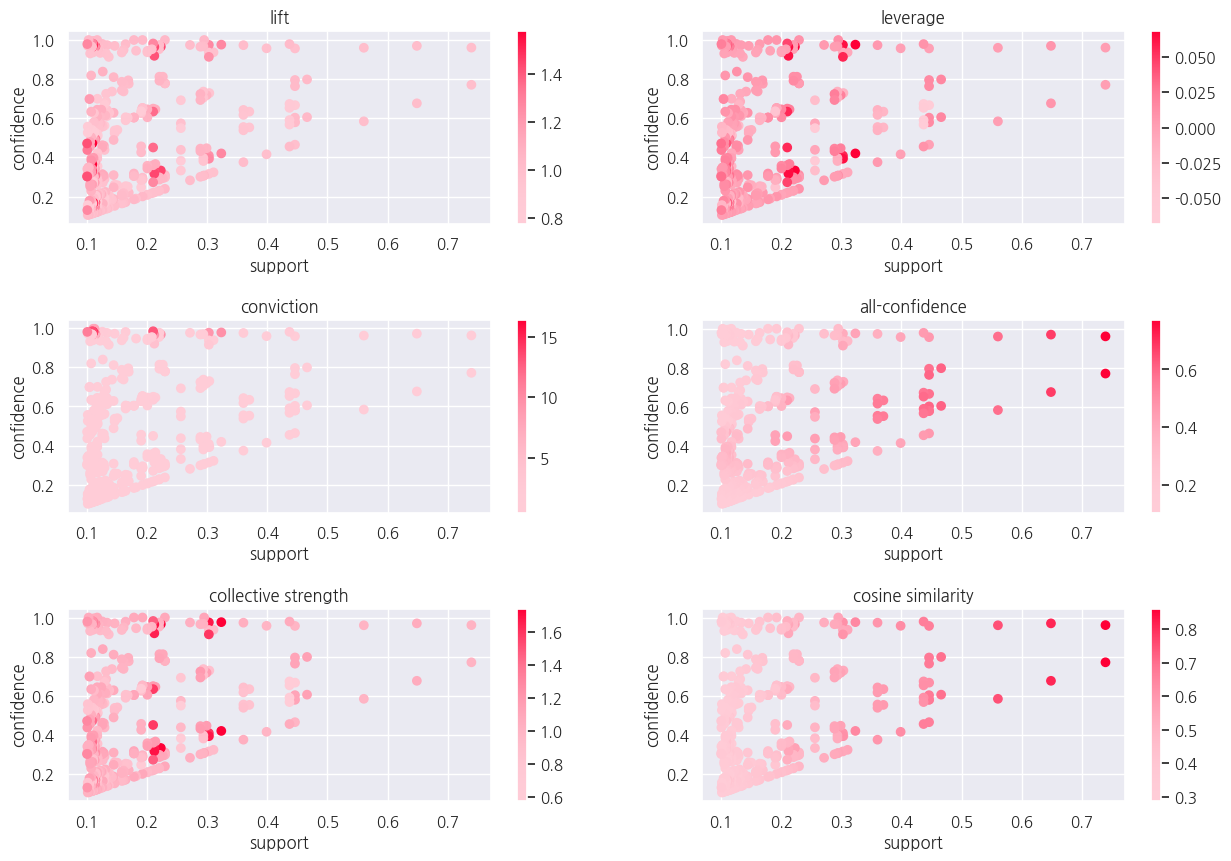

In [20]:
support = association_rules_df['support']
confidence = association_rules_df['confidence']
 
h = 347
s = 1
v = 1
colors = [
    mcl.hsv_to_rgb((h/360, 0.2, v)),
    mcl.hsv_to_rgb((h/360, 0.55, v)),
    mcl.hsv_to_rgb((h/360, 1, v))
]
cmap = LinearSegmentedColormap.from_list('my_cmap',colors,gamma=2)
 
measures = ['lift', 'leverage', 'conviction', 
            'all-confidence', 'collective strength', 'cosine similarity']
 
fig = plt.figure(figsize=(15,10))
fig.set_facecolor('white')
for i, measure in enumerate(measures):
    ax = fig.add_subplot(320+i+1)
    if measure != 'all-confidence':
        scatter = ax.scatter(support,confidence,c=association_rules_df[measure],cmap=cmap)
    else:
        scatter = ax.scatter(support,confidence,c=association_rules_df['all-confidence'].map(lambda x: [v for k,v in x.items()][0]),cmap=cmap)
    ax.set_xlabel('support')
    ax.set_ylabel('confidence')
    ax.set_title(measure)
    
    fig.colorbar(scatter,ax=ax)
fig.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# One-Hot-Encoding(labeling)

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
ICU['PRSC_NT'] = ICU['PRSC_NT'].astype(float)

# '측정안됨'을 NaN으로 변경
ICU.replace('측정안됨', np.nan, inplace=True)

# Column1 열의 데이터를 숫자로 변환 (NaN이 자동으로 유지됨)
ICU['DBP'] = pd.to_numeric(ICU['DBP'], errors='coerce')
ICU['SBP'] = pd.to_numeric(ICU['SBP'], errors='coerce')
ICU['맥박'] = pd.to_numeric(ICU['맥박'], errors='coerce')
ICU['체온'] = pd.to_numeric(ICU['체온'], errors='coerce')
ICU['호흡'] = pd.to_numeric(ICU['호흡'], errors='coerce')

In [23]:
ICU = ICU.dropna()

In [24]:
#트랜스포머를 통해 라벨링

ICU_1 = ICU.copy()

labelencoder=LabelEncoder()
for col in ICU_1.columns:
    ICU_1[col] = labelencoder.fit_transform(ICU_1[col])
    ICU_1.head()

In [25]:
ICU_1

,INGR_NM,PRSC_NT,TPRSC_CAPA,PRSC_CLS_NM,ATC_CONT,DBP,SBP,맥박,체온,호흡,ICD10CD,DIAG_NM,AGRDE,SEX_CD,RSLT_CONT,WTHN30_REHOSP_YN
VTHOS_NO,,,,,,,,,,,,,,,,
0x000d740f3af5d04f9f329e41cf15fefcbf747447dd55ea155c9be9ef3615a26d,1277,26,699,0,25,33,48,109,35,8,201,266,10,1,1,0
0x0013131e3997eab3578b9fb416e237319e1473845c038f45970265f03692cb5a,540,27,718,0,18,123,164,86,25,13,1816,3349,5,1,1,0
0x0013131e3997eab3578b9fb416e237319e1473845c038f45970265f03692cb5a,540,27,718,0,18,123,164,86,25,13,1816,3349,5,1,1,0
0x0013131e3997eab3578b9fb416e237319e1473845c038f45970265f03692cb5a,540,27,718,0,18,123,164,86,25,13,1816,3349,5,1,1,0
0x0013131e3997eab3578b9fb416e237319e1473845c038f45970265f03692cb5a,540,27,718,0,18,123,164,86,25,13,1816,3349,5,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xfffbc588a9f7c77ff76258fabe119256f048bfcf8ae1a8c877d921b584609a3a,1375,148,1919,0,12,70,110,69,31,12,3025,869,9,1,1,1
0xfffbc588a9f7c77ff76258fabe119256f048bfcf8ae1a8c877d921b584609a3a,1375,148,1919,0,12,70,110,69,31,12,3025,869,9,1,1,1
0xfffbc588a9f7c77ff76258fabe119256f048bfcf8ae1a8c877d921b584609a3a,1375,148,1919,0,12,70,110,69,31,12,3025,869,9,1,1,1


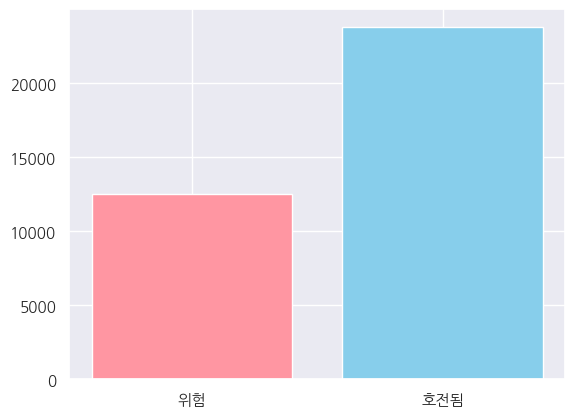

In [26]:
y = ICU_1['RSLT_CONT'].values

category_counts = np.bincount(y)

# Plotting
plt.bar([0, 1], category_counts, color=['#FF96A2', 'skyblue'])
plt.xticks([0, 1],['위험' , '호전됨'])
plt.show()

# 중환자 상관관계

In [27]:
import seaborn as sns

In [28]:
correlation_matrix = ICU_1.corr(method = 'pearson')

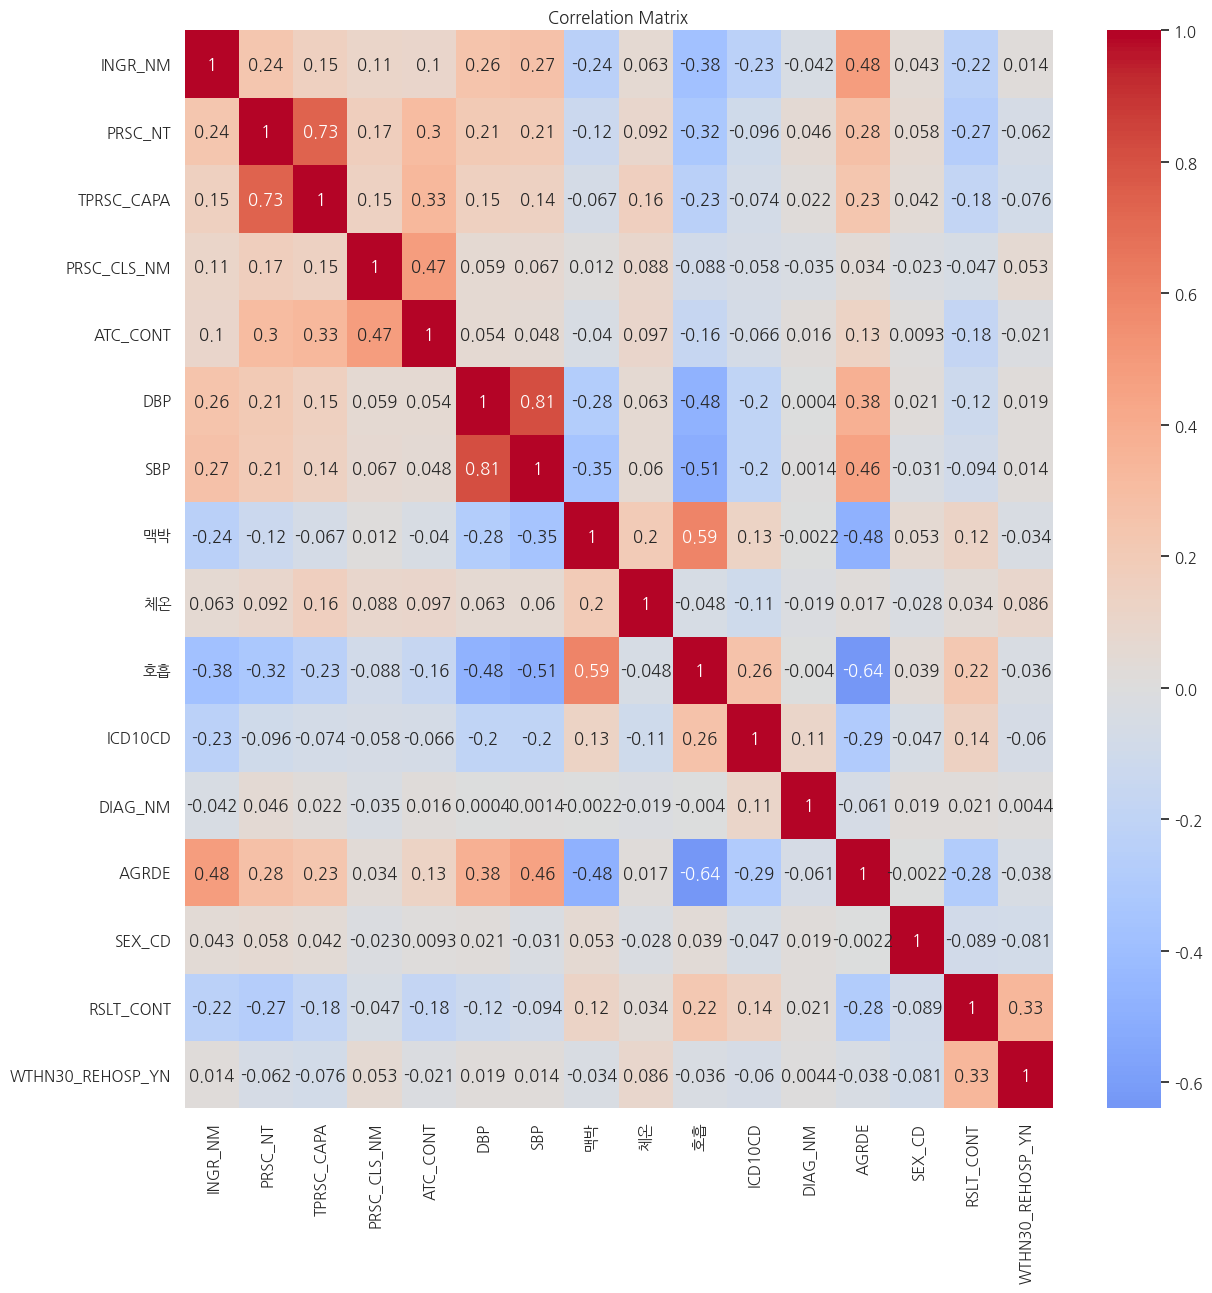

In [29]:
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# model

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from collections import Counter
from statistics import mean
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [31]:
X = ICU_1.drop(['RSLT_CONT'], axis=1)
y = ICU_1['RSLT_CONT']

In [32]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# 표준화 객체 생성
scaler = StandardScaler()

# 표준화 수행
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터도 같은 스케일로 변환

In [35]:
# 모델 정의
bagging_model = RandomForestClassifier(n_estimators=100, random_state=42)
boosting_model = HistGradientBoostingClassifier(random_state=42)
solver_algorithm = 'liblinear'  # 다른 알고리즘 선택
Logistic_model = LogisticRegression(solver=solver_algorithm)

In [36]:
# 모델 리스트 생성
models = [bagging_model, Logistic_model, boosting_model]
model_names = ['Bagging', 'Logistic', 'boosting']

In [37]:
plt.rcParams['font.family'] = 'Arial'  

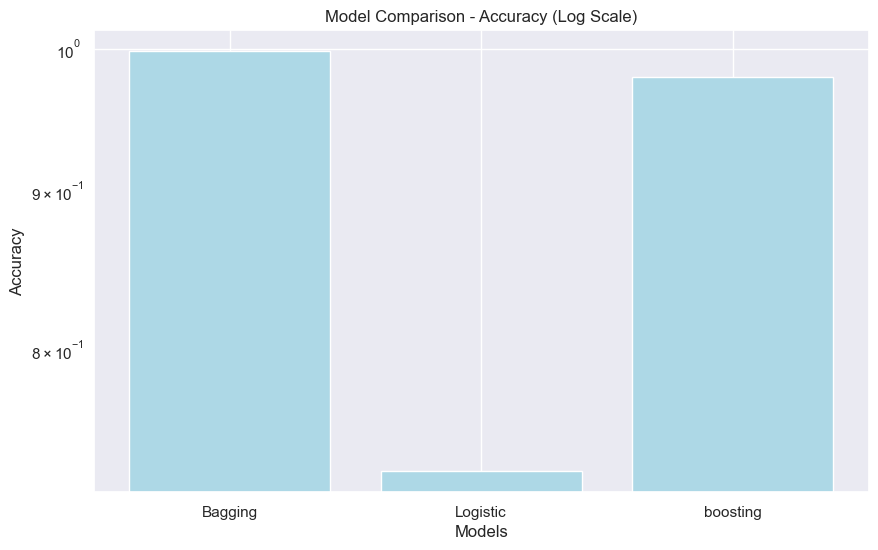

In [38]:
accuracies = []

# 모델 훈련 및 예측
for model in models:
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', model)
    ])
    
    pipeline.fit(X_train_scaled, y_train)
    y_pred = pipeline.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# 로그 스케일 적용
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='lightblue')  # 색상 변경
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy (Log Scale)')  # 제목 변경
plt.yscale('log')  # 로그 스케일 적용
plt.show()

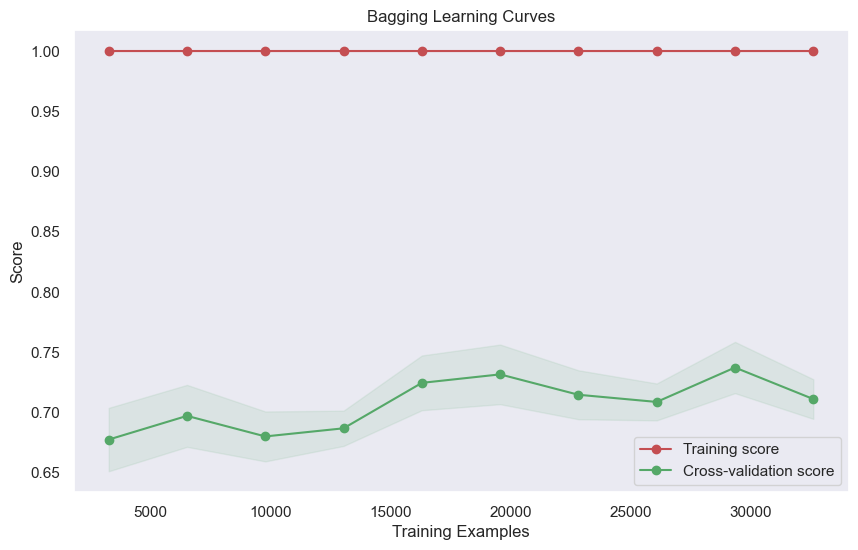

In [37]:
# Learning Curves 계산
train_sizes, train_scores, valid_scores = learning_curve(
    bagging_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# 평균과 표준편차 계산
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Learning Curves 그리기
plt.figure(figsize=(10, 6))
plt.title("Bagging Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

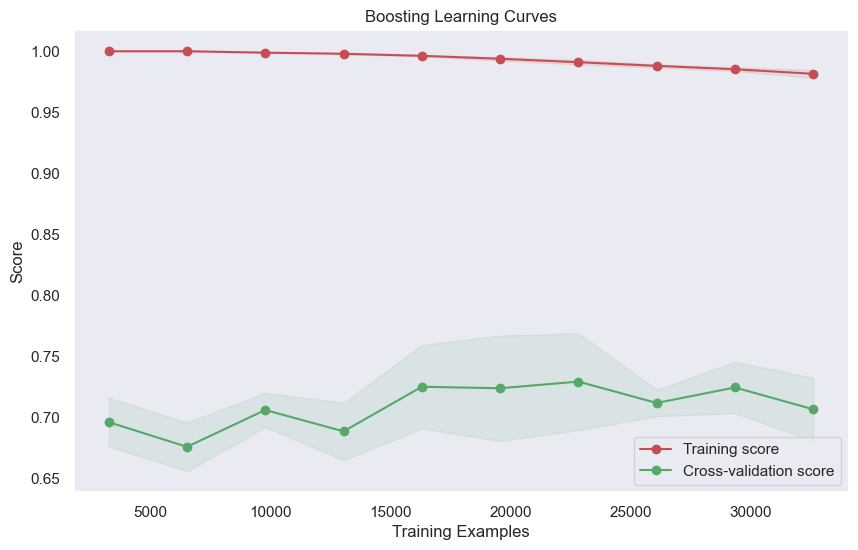

In [38]:
# Learning Curves 계산
train_sizes, train_scores, valid_scores = learning_curve(
    boosting_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# 평균과 표준편차 계산
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Learning Curves 그리기
plt.figure(figsize=(10, 6))
plt.title("Boosting Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

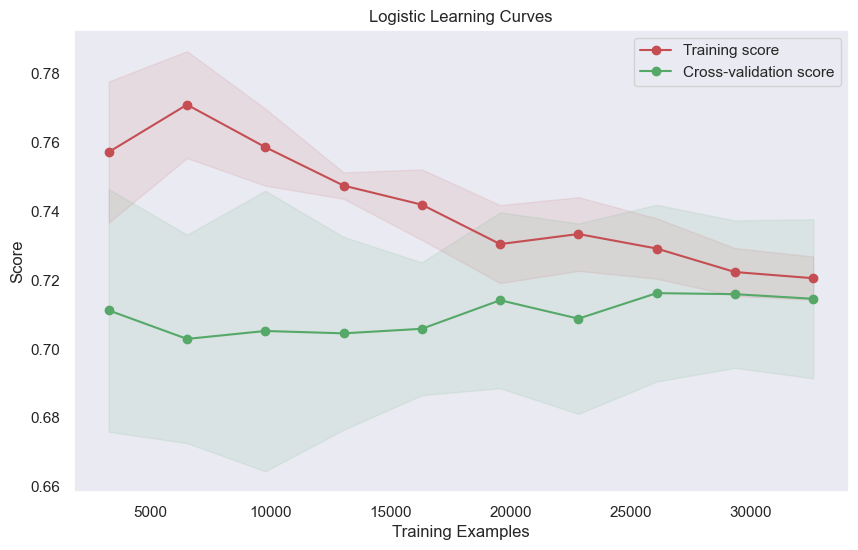

In [39]:
# Learning Curves 계산
train_sizes, train_scores, valid_scores = learning_curve(
    Logistic_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# 평균과 표준편차 계산
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Learning Curves 그리기
plt.figure(figsize=(10, 6))
plt.title("Logistic Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

## 배깅,부스팅 과적합 Logistic은 과적합은 발생 안하지만 성능이 낮음

## Grid search (하이퍼 파라미터 튜닝)

In [40]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['liblinear']}

# L1 규제 모델에 대한 그리드 서치 객체 생성
l1_logreg = LogisticRegression(penalty='l1')
grid_search_l1 = GridSearchCV(estimator=l1_logreg, param_grid=param_grid, cv=5)

# L2 규제 모델에 대한 그리드 서치 객체 생성
l2_logreg = LogisticRegression(penalty='l2')
grid_search_l2 = GridSearchCV(estimator=l2_logreg, param_grid=param_grid, cv=5)

# 그리드 서치 수행
grid_search_l1.fit(X_train_scaled, y_train)
grid_search_l2.fit(X_train_scaled, y_train)

# 최적 모델 확인
best_model_l1 = grid_search_l1.best_estimator_
best_model_l2 = grid_search_l2.best_estimator_

In [41]:
print("Best parameters for L1 regularization:", grid_search_l1.best_params_)
print("Best parameters for L2 regularization:", grid_search_l2.best_params_)

Best parameters for L1 regularization: {'C': 0.001, 'solver': 'liblinear'}
Best parameters for L2 regularization: {'C': 10, 'solver': 'liblinear'}


In [42]:
accuracy = best_model_l1.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.5720770457612563


C:\Users\kinsh\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [43]:
accuracy = best_model_l2.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.6719420929947246


C:\Users\kinsh\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# Deep learning (Binary-cross-entropy)

In [39]:
import tensorflow as tf
from sklearn.impute import SimpleImputer

C:\Users\kinsh\anaconda3\Lib\site-packages\tensorflow\python\debug\cli\debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
C:\Users\kinsh\anaconda3\Lib\site-packages\botocore\utils.py:15: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi
C:\Users\kinsh\anaconda3\Lib\site-packages\botocore\httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


In [40]:
# SimpleImputer 객체 생성
imputer = SimpleImputer(strategy='mean')  # strategy='mean'은 평균값으로 대체함을 의미

# NaN 값을 열의 평균값으로 대체
ICU_imputed = imputer.fit_transform(ICU_1)

In [41]:
plt.rcParams["font.family"] = 'NanumGothic'
sns.set(font='NanumGothic')

In [42]:
DNN_model = tf.keras.Sequential([tf.keras.layers.Dense(units=24, activation='relu', input_shape=(15,)),
                            tf.keras.layers.Dense(units=8, activation='relu'),
                            tf.keras.layers.Dense(units=1, activation='sigmoid')
])
DNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', metrics=['accuracy'])

DNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                384       
                                                                 
 dense_1 (Dense)             (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 593 (2.32 KB)
Trainable params: 593 (2.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
history = DNN_model.fit(X_train_scaled, y_train, epochs=100, batch_size=36, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

Epoch 1/100
605/605 [==============================] - 1s 1ms/step - loss: 0.5158 - accuracy: 0.7291 - val_loss: 0.4493 - val_accuracy: 0.7668
Epoch 2/100
605/605 [==============================] - 1s 1ms/step - loss: 0.4421 - accuracy: 0.7758 - val_loss: 0.4291 - val_accuracy: 0.7804
Epoch 3/100
605/605 [==============================] - 1s 980us/step - loss: 0.4204 - accuracy: 0.7930 - val_loss: 0.4101 - val_accuracy: 0.7930
Epoch 4/100
605/605 [==============================] - 1s 1ms/step - loss: 0.4018 - accuracy: 0.8064 - val_loss: 0.3963 - val_accuracy: 0.8092
Epoch 5/100
605/605 [==============================] - 1s 1ms/step - loss: 0.3844 - accuracy: 0.8187 - val_loss: 0.3800 - val_accuracy: 0.8222
Epoch 6/100
605/605 [==============================] - 1s 982us/step - loss: 0.3681 - accuracy: 0.8265 - val_loss: 0.3677 - val_accuracy: 0.8259
Epoch 7/100
605/605 [==============================] - 1s 1ms/step - loss: 0.3533 - accuracy: 0.8364 - val_loss: 0.3554 - val_accuracy: 0.

In [44]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

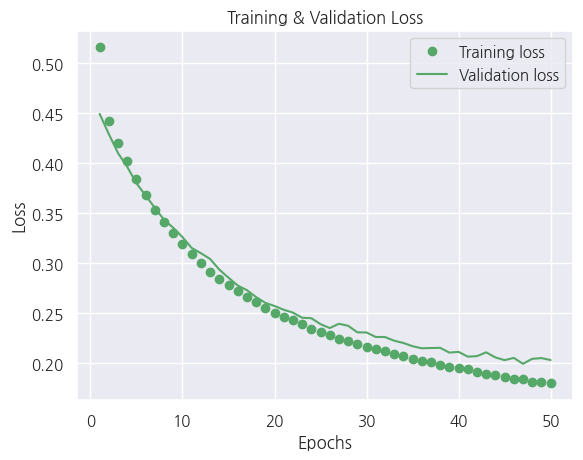

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'go', label='Training loss') #go : green dot
plt.plot(epochs, val_loss, 'g', label='Validation loss') #g : green line
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

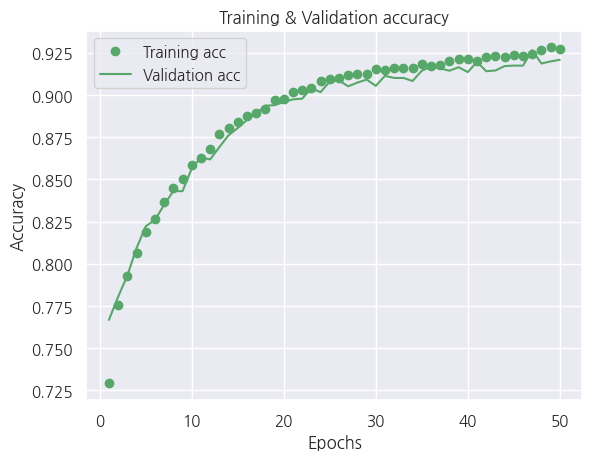

In [46]:
plt.clf() #그래프 초기화하기
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'go', label='Training acc') #go : green dot
plt.plot(epochs, val_acc, 'g', label='Validation acc') #g : green line
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
# h5 저장

from keras.models import save_model

DNN_model.save('DNN_model.keras')

## ROC 커브

227/227 [==============================] - 1s 3ms/step


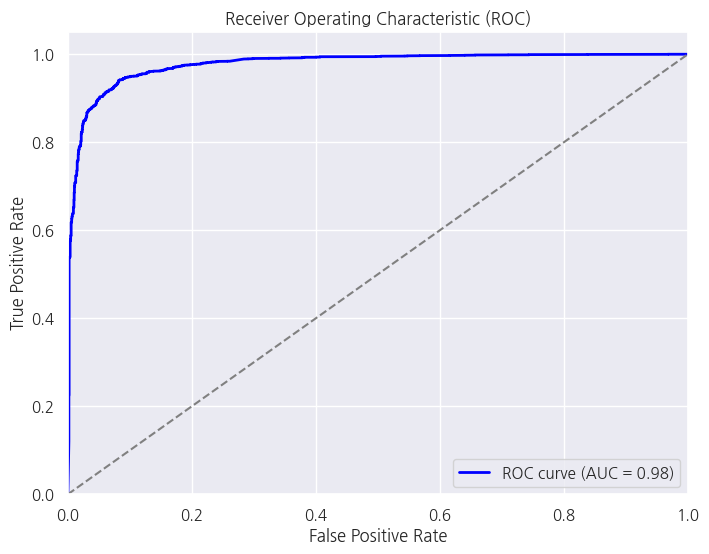

In [231]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 테스트 데이터에 대한 예측 확률 계산
DNN_probs = DNN_model.predict(X_test_scaled)

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test, DNN_probs)

# AUC 계산
roc_auc = roc_auc_score(y_test, DNN_probs)

# ROC 커브 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Ensemble

### 1.DNN. bagging, logisitc 조합

In [85]:
from tensorflow.keras import Sequential
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from tensorflow.keras.layers import Dense

In [86]:
# 앙상블에 사용하기 위해 DNN 커스터마이징
class CustomKerasModel(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=10, batch_size=32, verbose=0):
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None
        self.is_fitted_ = False  
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        
        self.model = self.create_dnn_model(X.shape[1])
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        
        self.is_fitted_ = True  
        
        return self
    
    def predict(self, X):
        self._check_is_fitted()
        X = check_array(X)
        y_pred = self.model.predict(X)
        y_pred_classes = (y_pred > 0.5).astype(int)
        return y_pred_classes
    
    def predict_proba(self, X):
        self._check_is_fitted()
        X = check_array(X)
        probabilities = self.model.predict(X)
        return np.column_stack((1 - probabilities, probabilities))
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def create_dnn_model(self, input_shape):
        model = Sequential([
            Dense(units=24, activation='relu', input_shape=(input_shape,)),
            Dense(units=8, activation='relu'),
            Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def _check_is_fitted(self):
        if not self.is_fitted_:
            raise NotFittedError("This CustomKerasModel instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")
        return self.model

In [87]:
# 사용자 정의 Keras 모델 생성
custom_dnn_model = CustomKerasModel(epochs=10, batch_size=32, verbose=0)

# DNN 모델 학습
custom_dnn_model.fit(X_train_scaled, y_train)

CustomKerasModel()

In [88]:
# 앙상블 모델 정의 및 학습
ensemble_models = [('bagging_model', bagging_model), ('DNN', custom_dnn_model), ('Logistic_model', Logistic_model)]
voting_ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')
voting_ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('bagging_model',
                              RandomForestClassifier(random_state=42)),
                             ('DNN', CustomKerasModel()),
                             ('Logistic_model',
                              LogisticRegression(solver='liblinear'))],
                 voting='soft')

In [89]:
# 앙상블 모델을 사용하여 예측 수행
ensemble_predictions = voting_ensemble.predict(X_test_scaled)

255/255 [==============================] - 0s 1ms/step


In [90]:
# 정확도 계산
accuracy = accuracy_score(y_test, ensemble_predictions)
print("앙상블 모델의 정확도:", accuracy)

앙상블 모델의 정확도: 0.9790209790209791


1019/1019 [==============================] - 3s 3ms/step


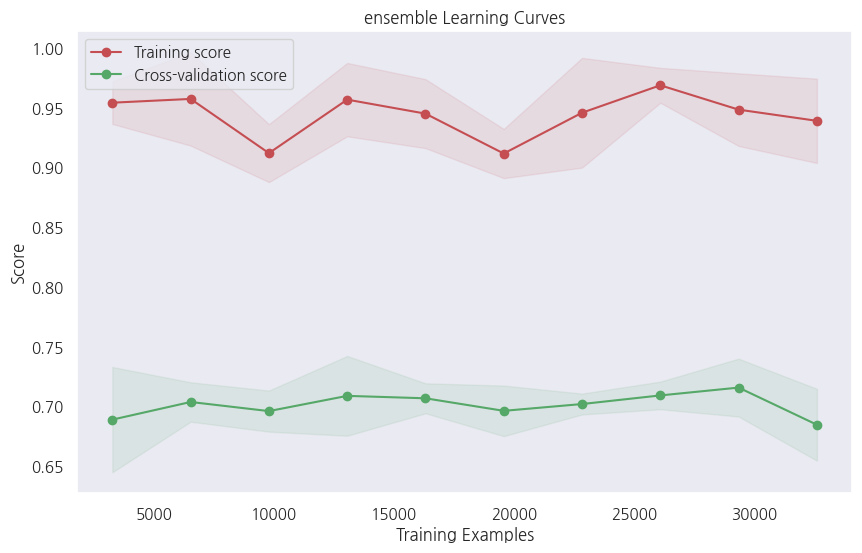

In [91]:
# Learning Curves 계산
train_sizes, train_scores, valid_scores = learning_curve(
    voting_ensemble, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# 평균과 표준편차 계산
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Learning Curves 그리기
plt.figure(figsize=(10, 6))
plt.title("ensemble Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

### 2.DNN, logisitc 조합

In [232]:
# 앙상블 모델 정의 (앙상블 모델의 이름 변경)
ensemble_models = [('Logistic_model', Logistic_model), ('DNN', custom_dnn_model)]
voting_ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')

In [233]:
# 앙상블 모델 학습
voting_ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('Logistic_model',
                              LogisticRegression(solver='liblinear')),
                             ('DNN', CustomKerasModel())],
                 voting='soft')

In [234]:
# 앙상블 모델 예측 결과 얻기
ensemble_predictions = voting_ensemble.predict(X_test_scaled)

# 예측 결과 출력
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_predictions))

227/227 [==============================] - 1s 3ms/step
Ensemble Accuracy: 0.8628532046864231


In [ ]:
# Learning Curves 계산
train_sizes, train_scores, valid_scores = learning_curve(
    voting_ensemble, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=3)

# 평균과 표준편차 계산
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Learning Curves 그리기
plt.figure(figsize=(10, 6))
plt.title("ensemble Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()